Автор:     Шестаков Михаил Сергеевич  
Telegram:  https://t.me/mshestakov1  
email:     mikhail-shestakov-2022@bk.ru  

# A/B-тестирование изменений на сайте интернет-магазина

***Заказчик исследования:*** отдел маркетинга интернет-магазина.

***Цели исследования:***  
1. Выявить приоритетную гипотезу по увеличению выручки.
2. На основании результатов A/B-теста за первый месяц определить, стоит ли продолжать тестирование или полученных данных достаточно для того, чтобы принять или отклонить гипотезу.

***Описание данных*** 

Исходные данные:  
1. Перечень гипотез.
2. Результаты A/B-теста за первый месяц.

Исходные данные содержатся в следующих файлах:

- hypothesis.csv — информация о гипотезах;
- orders.csv — информация о заказах;
- visitors.csv — информация о посещениях;

 

В таблице hypothesis представлены следующие данные: 

- hypothesis — краткое описание гипотезы;
- reach — охват пользователей по 10-балльной шкале;
- impact — влияние на пользователей по 10-балльной шкале;
- confidence — уверенность в гипотезе по 10-балльной шкале;
- efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

 

В таблице orders представлены следующие данные: 

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

 

В таблице visitors представлены следующие данные: 

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

***Содержание исследования:***  
1. [Приоритизация гипотез](#hypotheses)  
 1.1. [ICE](#ice)  
 1.2. [RICE](#rice)    
    * [Вывод](#final_1)    
    
    
2. [Анализ A/B-теста](#ABtest)  
 2.1. [Функции обработки данных](#functions)  
 2.1. [Общая информация о датафреймах](#info_all)  
 2.2. [Предобработка данных](#change_type)  
 2.4. [Анализ сырых данных](#raw_data_analysis)  
 2.5. [Анализ выбросов и всплесков: крайние значения данных](#emissions)  
 2.6. [Анализ очищенных данных](#analysis_cleared_data)  
    * [Вывод](#final_2)    
    

5. [Общий вывод](#final)  

## Приоритизация гипотез
<a id="hypotheses"></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import datetime as dt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Создаем датафрейм с информацией по гипотезам:

In [2]:
df_hyp = pd.read_csv('/datasets/hypothesis.csv')
pd.options.display.max_colwidth = 210

Выводим таблицу:

In [3]:
df_hyp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Выводим общую информацию по датафрейму:

In [4]:
df_hyp.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 2.7 KB


### ICE
<a id="ice"></a>

***Описание метода***

Фреймворк ICE состоит из трех компонентов:  
- Reach — скольких пользователей затронет изменение;  
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;  
- Confidence — степень уверенности в том, что изменение повлияет на пользователей именно так, как предполагается.  

Фреймворк ICE рассчитывается по формуле:  
ICE = Reach * Impact * Confidence  

Значения компонентов фреймворка ICE оцениваются по шкале от 1 до 10, чтобы все факторы сбалансировано повлияли на итоговое число.

***Приоретизация гипотез по методу ICE***

Строим точечную диаграмму значений компонентов фреймворка ICE по гипотезам:

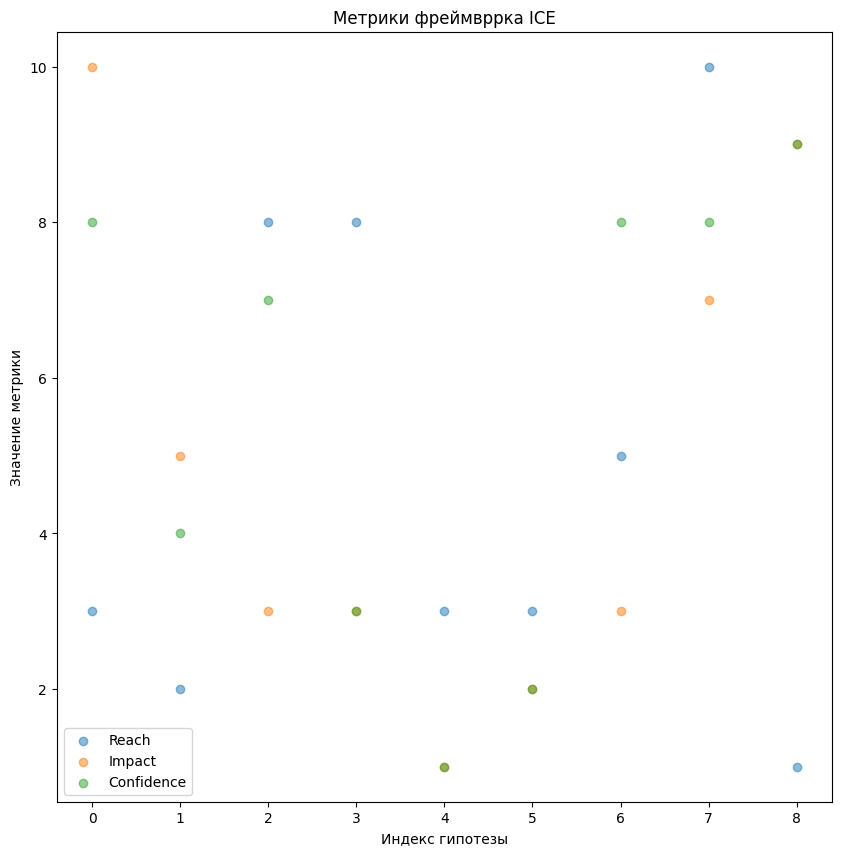

In [5]:
plt.figure(figsize=(10,10))
for i in df_hyp.columns[1:4]:
    ax1 = plt.scatter(df_hyp.index, df_hyp[i], label = i, alpha=0.5)
ax1 = plt.title('Метрики фреймвррка ICE')
ax1 = plt.ylabel('Значение метрики')
ax1 = plt.xlabel('Индекс гипотезы')
ax1 = plt.legend() 

Рассчитываем ICE:

In [6]:
df_hyp['ice'] = (df_hyp['Impact'] * df_hyp['Confidence']) / df_hyp['Efforts']
df_hyp[['Hypothesis', 'ice']].sort_values(by='ice', ascending = False).reset_index()

,index,Hypothesis,ice
0,8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
1,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
2,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
4,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
5,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
6,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
7,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Производим приоретизацию гипотез по методу RICE:

### RICE
<a id="rice"></a>

***Описание метода***

Фреймворк ICE состоит из трех компонентов:  
- Reach — скольких пользователей затронет изменение;  
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;  
- Confidence — степень уверенности в том, что изменение повлияет на пользователей именно так, как предполагается;  
- Efforts — стоимость проверки гипотезы.

Фреймворк ICE рассчитывается по формуле:  
ICE = Reach * Impact * Confidence / Efforts

Значения компонентов фреймворка RICE оцениваются по шкале от 1 до 10, чтобы все факторы сбалансировано повлияли на итоговое число.

***Приоретизация гипотез по методу RICE***

Строим точечные диаграммы значений метрик прямо и обратно пропорциональных приоритету гипотез:

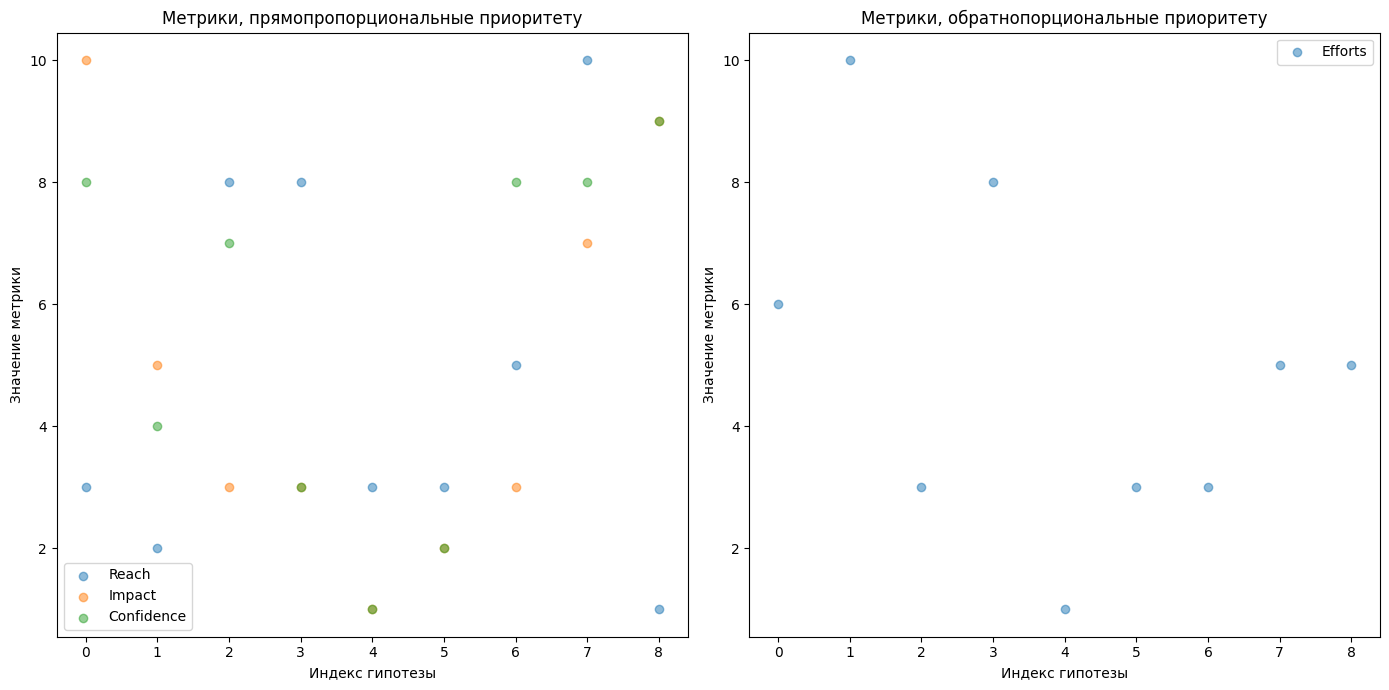

In [7]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(1, 2, 1)
for i in df_hyp.columns[1:4]:
    ax1 = plt.scatter(df_hyp.index, df_hyp[i], label = i, alpha=0.5)
ax1 = plt.title('Метрики, прямопропорциональные приоритету')
ax1 = plt.ylabel('Значение метрики')
ax1 = plt.xlabel('Индекс гипотезы')
ax1 = plt.legend()  

ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.scatter(df_hyp.index, df_hyp['Efforts'], label = 'Efforts', alpha=0.5)
ax2 = plt.title('Метрики, обратнопорциональные приоритету')
ax2 = plt.ylabel('Значение метрики')
ax2 = plt.xlabel('Индекс гипотезы')
ax2 = plt.legend() 

fig.tight_layout()
plt.show()

Рассчитываем RICE:

In [8]:
df_hyp['rice'] = (df_hyp['Reach'] * df_hyp['Impact'] * df_hyp['Confidence']) / df_hyp['Efforts']
df_hyp[['Hypothesis', 'rice']].sort_values(by='rice', ascending = False).reset_index()

,index,Hypothesis,rice
0,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
1,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
2,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
4,8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
5,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
6,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
7,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### ICE + RICE
<a id="rice"></a>

Объединяем результаты ICE и RICE:

In [9]:
df_hyp[['Hypothesis', 'rice', 'ice']].sort_values(by=['rice', 'ice'], ascending=False).reset_index(drop=True)

,Hypothesis,rice,ice
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.200000
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.000000
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.333333
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.000000
4,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.200000
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.125000
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.000000
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.333333
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.000000


***Вывод:***
<a id="final_1"></a>
1. По методу ICE наибольший приоритет имеют гипотезы:  
- "запустить акцию, дающую скидку на товар в день рождения" - 16.2 балла;  
- "добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" - 13.3 балла;  
- "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - 11.2 балла;  

2. По методу RICE наибольший приоритет имеют гипотезы:  
- "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - 112.0 баллов;  
- "добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" - 56.0 баллов;  
- "добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" - 40.0 балла;  

3. В методе RICE, в отличие от ICE, учитывается скольких пользователей затронет изменение (параметр "Reach"). По сумме баллов, полученных методами ICE и RICE, наивысший приоритет имеет гипотеза "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", главным образом потому, что данное изменение косается большинства пользователей: основные страницы посещают практически все. Для проведения A/B-теста следует выбрать именно данную гипотезу.

## Анализ A/B-теста
<a id="ABtest"></a>

### Функции обработки данных
<a id="functions"></a>

In [10]:
# сводная таблица заказов и посещений
def pivot_table(df_ord, df_vis):
    df_ord_pivot = (
        df_ord
                .pivot_table(index= 'group', values= ['order_id', 'user_id', 'revenue'],
                             aggfunc= {'order_id': 'count', 'user_id' : 'nunique', 'revenue' : 'sum'})
                .rename(columns={'order_id' : 'orders', 'user_id' : 'users'})
    )
    
    df_vis_pivot = (
        df_vis
                .pivot_table(index= 'group', values= ['visitors'],
                             aggfunc= {'visitors': 'sum'})
    )
    
    df_pivot = df_ord_pivot.merge(df_vis_pivot, left_on='group', right_on='group', how='left')
    return df_pivot

In [11]:
# Общая информация
def information(dict_df):
    for i in dict_df:
        print(i)
        print()
        print('Общая информация {}:'.format(i))
        display(dict_df[i].info(memory_usage='deep'))
        print('____________________________________________________')
        print()
        print('Описательная статистика числовых значений {}:'.format(i))
        display(dict_df[i].describe().T)
        print('____________________________________________________')
        print()
        print('Процент пропущенных значений {}:'.format(i))
        display(dict_df[i].isna().mean()*100)
        print('____________________________________________________')
        print()
        print('Случайная выборка датафрейма {}:'.format(i))
        if dict_df[i].shape[0] > 15:
            display(dict_df[i].sample(n = 5, random_state = 0))
        else:
            display(dict_df[i].sample(n = dict_df[i].shape[0], random_state = 0))
        print('____________________________________________________')
        print('____________________________________________________')
        print()
    return None

In [12]:
# Очистка таблицы visitors
def reset_visitors(df_orders_first, df_orders_last, df_visitors_first, abnormal_users):
# количество визитов не прошедших фильтрацию пользователей по месяцам
    reset_ord = (
        df_orders_first
            .loc[df_orders_first['user_id'].isin(abnormal_users)]
            .groupby('date', as_index=False)
            .agg({'order_id' : 'count'})
            .rename(columns = {'order_id' : 'drop_visitors'})
    )

    # визиты без учета тех, которые совершили пользователи, не прошедшие фильтрации
    reset_vis = (
        df_visitors_first
            .merge(reset_ord, left_on='date', right_on='date', how='left')
            .rename(columns = {'visitors' : 'start_visitors'})
            .assign(visitors = lambda x: x['start_visitors'] - x['drop_visitors'].fillna(0))
    )
    reset_vis = reset_vis[['date', 'group', 'visitors']]
    
    # Процент исключенных из исследования посещений и уникальных пользователей
    bad_users = (len(df_orders_first['user_id'].unique()) - len(df_orders_last['user_id'].unique())) / len(df_orders_first['user_id'].unique()) 
    bad_visits = (df_visitors_first['visitors'].sum() - reset_vis['visitors'].sum()) / df_visitors_first['visitors'].sum()
    print('Исключено из исследования уникальных пользователей - {:.1%}'.format(bad_users))
    print('Исключено из исследования посещений - {:.1%}'.format(bad_visits))
    
    return reset_vis

In [13]:
# количество и сумма заказов по дням
def orders_daily(df, group):
    df_orders_daily = (
    df
        .loc[df['group'] == group]
        .groupby('date', as_index=False)
        .agg({'order_id' : pd.Series.nunique, 'revenue' : 'sum'})
    )
    df_orders_daily.columns = ['date', 'orders_per_date_' + group.lower(), 'revenue_per_date_'+ group.lower()]
    return df_orders_daily

In [14]:
# количество посетителей по дням
def visitors_daily(df, group):
    df_visitors_startDaily = df[df['group'] == group][['date', 'visitors']]
    df_visitors_startDaily.columns = ['date', 'visitors_per_date_' + group.lower()]
    return df_visitors_startDaily

In [15]:
# кумулятивные данные заказов по дням
def orders_cummulative(df, group):
    df_orders_cummulative = df.apply(lambda x: df[df['date'] <= x['date']].agg({'date' : 'max', df.columns[1]: 'sum', df.columns[2]: 'sum'}), axis=1).sort_values(by=['date'])
    df_orders_cummulative.columns = ['date', 'orders_cummulative_' + group.lower(), 'revenue_cummulative_' + group.lower()]
    return df_orders_cummulative

In [16]:
# кумулятивные данные посещений по дням
def visitors_cummulative(df, group):
    df_visitors_start_cummulative = df.apply(lambda x: df.loc[df['date'] <= x['date']]
                                       .agg({'date' : 'max', df.columns[1] : 'sum'}), axis=1)
    df_visitors_start_cummulative.columns = ['date', 'visitors_cummulative_' + group.lower()]
    return df_visitors_start_cummulative

In [17]:
# количество заказов каждого пользователя
def users_orders(df, group):
    df_users_orders = (
        df
            .loc[df['group'] == group]
            .groupby('user_id', as_index=False)
            .agg({'order_id' : pd.Series.nunique, 'revenue' : 'sum'})
    )
    df_users_orders.columns = ['user_id', 'orders', 'revenue']
    return df_users_orders

In [18]:
# Сумма заказов каждого пользователя определенной группы
def for_mean_receipt(group):
    group_revenue = df_orders[np.logical_and(df_orders['group'] == group,
                                             np.logical_not(df_orders['user_id'].isin(abnormal_users)),)]['revenue']
    return group_revenue

In [19]:
# Все визиты и заказы по группам для расчета конверсии
def conversion(df, orders_by_users, group):
    no_buy_users = pd.Series(0, index=np.arange(df[df['group']==group]['visitors'].sum() - len(orders_by_users['orders'])), name='orders')
    total_visits = pd.concat([orders_by_users['orders'], no_buy_users])
    return total_visits

In [20]:
# отрисовка диаграмм
def charts(df):
    fig = plt.figure(figsize=(10,50))

    # кумулятивная выручка
    ax1 = fig.add_subplot(5, 1, 1)
    ax1 = plt.plot(df['date'], df['revenue_cummulative_a'], label='A')
    ax1 = plt.plot(df['date'], df['revenue_cummulative_b'], label='B')
    ax1 = plt.title('Кумулятивная выручка группы "B" больше')
    ax1 = plt.ylabel('Кумулятивная выручка')
    ax1 = plt.xlabel('Дата')
    ax1 = plt.xticks(rotation=45)
    ax1 = plt.legend() 

    # кумулятивный средний чек
    ax2 = fig.add_subplot(5, 1, 2)
    ax2 = plt.plot(df['date'], df['revenue_cummulative_a'] / df['orders_cummulative_a'], label='A')
    ax2 = plt.plot(df['date'], df['revenue_cummulative_b'] / df['orders_cummulative_b'], label='B')
    ax2 = plt.title('Кумулятивный средний чек группы "B" больше')
    ax2 = plt.ylabel('Кумулятивный средний чек')
    ax2 = plt.xlabel('Дата')
    ax2 = plt.xticks(rotation=45)
    ax2 = plt.legend()

    # различие кумулятивных средних чеков
    ax3 = fig.add_subplot(5, 1, 3)
    ax3 = plt.plot(df['date'], (df['revenue_cummulative_b'] / df['orders_cummulative_b']) /
         (df['revenue_cummulative_a'] / df['orders_cummulative_a'])-1)
    ax3 = plt.axhline(y=0, color='black', linestyle='--') 
    ax3 = plt.title('Различие кумулятивных средних чеков стремится к нулю')
    ax3 = plt.ylabel('Отношение кумулятивных средних чеков')
    ax3 = plt.xlabel('Дата')
    ax3 = plt.xticks(rotation=45)

    # кумулятивная конверсия
    ax4 = fig.add_subplot(5, 1, 4)
    ax4 = plt.plot(df['date'], df['conversion_a'], label='A')
    ax4 = plt.plot(df['date'], df['conversion_b'], label='B')
    ax4 = plt.title('Кумулятивная конверсия группы "B" закрепилась выше группы "A"')
    ax4 = plt.ylabel('Кумулятивная конверсия')
    ax4 = plt.xlabel('Дата')
    ax4 = plt.xticks(rotation=45)

    # относительный прирост конверсии группы "B" относительно группы "A"
    last_b_a = df.loc[df['date'] == df['date'].max()]['conversion_b'].sum() /\
               df.loc[df['date'] == df['date'].max()]['conversion_a'].sum() - 1
    ax5 = fig.add_subplot(5, 1, 5)
    ax5 = plt.plot(df['date'], df['conversion_b'] / df['conversion_a'] - 1)
    ax5 = plt.title('Относительный прирост конверсии группы "B" относительно группы "A" - {:.0%}'.format(last_b_a))
    ax5 = plt.xlabel('Дата')
    ax5 = plt.xticks(rotation=45)
    ax5 = plt.axhline(y=0, color='black', linestyle='--')
    ax5 = plt.axhline(y=last_b_a, color='grey', linestyle='--')

    fig.tight_layout()
    plt.show()
    return None

### Общая информация о датафреймах
<a id="info_all"></a>

Создаем датафреймы с информацией по заказам и посещениям:

In [21]:
df_orders_start = pd.read_csv('/datasets/orders.csv')
df_visitors_start = pd.read_csv('/datasets/visitors.csv')

Выводим общую информацию по каждому датафрейму:

In [22]:
dict_df = {'df_orders_start' : df_orders_start, 'df_visitors_start' : df_visitors_start}
for i in dict_df:
    print(i)
    print()
    print('Общая информация {}:'.format(i))
    display(dict_df[i].info(memory_usage='deep'))
    print('____________________________________________________')
    print()
    print('Описательная статистика числовых значений {}:'.format(i))
    display(dict_df[i].describe().T)
    print('____________________________________________________')
    print()
    print('Процент пропущенных значений {}:'.format(i))
    display(dict_df[i].isna().mean()*100)
    print('____________________________________________________')
    print()
    print('Случайная выборка датафрейма {}:'.format(i))
    if dict_df[i].shape[0] > 15:
        display(dict_df[i].sample(n = 5, random_state = 0))
    else:
        display(dict_df[i].sample(n = dict_df[i].shape[0], random_state = 0))
    print('____________________________________________________')
    print('____________________________________________________')
    print()

df_orders_start

Общая информация df_orders_start:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 174.3 KB


None

____________________________________________________

Описательная статистика числовых значений df_orders_start:


,count,mean,std,min,25%,50%,75%,max
transactionId,1197.0,2.155621e+09,1.229085e+09,1062393.0,1.166776e+09,2.145194e+09,3.237740e+09,4.293856e+09
visitorId,1197.0,2.165960e+09,1.236014e+09,5114589.0,1.111826e+09,2.217985e+09,3.177606e+09,4.283872e+09
revenue,1197.0,8.348006e+03,3.919113e+04,50.0,1.220000e+03,2.978000e+03,8.290000e+03,1.294500e+06


____________________________________________________

Процент пропущенных значений df_orders_start:


transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

____________________________________________________

Случайная выборка датафрейма df_orders_start:


,transactionId,visitorId,date,revenue,group
700,2472751116,2328791559,2019-08-07,2070,B
621,380504587,1831140265,2019-08-29,26550,A
319,2414788465,2247745159,2019-08-19,1435,B
837,769008348,583433650,2019-08-08,5840,B
761,1109375840,2924874435,2019-08-07,990,A


____________________________________________________
____________________________________________________

df_visitors_start

Общая информация df_visitors_start:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


None

____________________________________________________

Описательная статистика числовых значений df_visitors_start:


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0


____________________________________________________

Процент пропущенных значений df_visitors_start:


date        0.0
group       0.0
visitors    0.0
dtype: float64

____________________________________________________

Случайная выборка датафрейма df_visitors_start:


,date,group,visitors
30,2019-08-31,A,699
32,2019-08-02,B,581
33,2019-08-03,B,509
48,2019-08-18,B,737
51,2019-08-21,B,656


____________________________________________________
____________________________________________________



***Вывод:***
1. Датафрейм df_orders_start (информация о заказах):  
 1.1. В датафрейме 1197 строк и 5 полей. Размер датафрейма 22.5 KB, пропущенных значений нет.  
 1.2. Поле "date" (дата, когда был совершён заказ) имеет тип "object". Следует изменить на тип "datetime64".  
 1.3. Поле "group" (группа A/B-теста) – object. Целесообразно заменить тип на "category".  

2. Датафрейм df_visitors_start (информация о посещениях):  
 1.1. В датафрейме 62 строки и 3 поля. Размер датафрейма 8.4 KB, пропущенных значений нет.  
 1.2. Поле "date" (дата) имеет тип "object". Следует изменить на тип "datetime64".  
 1.3. Поле "group" (группа A/B-теста) – object. Целесообразно заменить тип на "category".  

### Предобработка данных
<a id="change_type"></a>

***Оптимизация типов данных***

Изменяем тип полей "date":

In [23]:
df_orders_start['date'] = df_orders_start['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
df_visitors_start['date'] = df_visitors_start['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Изменяем тип полей "group":

In [24]:
try:
    df_orders_start['group'] = df_orders_start['group'].astype('category')
except:
    print('Тип данных поля "group" таблицы orders не изменен')
    
try:
    df_visitors_start['group'] = df_visitors_start['group'].astype('category')
except:
    print('Тип данных поля "group" таблицы visitors не изменен')

Изменяем типы полей "transactionId" и "visitorId" на "uint32" (и переименовываем их), а "revenue" - на "uint16":

In [25]:
df_orders_start = (
    df_orders_start
    .astype({'transactionId' : 'uint32', 'visitorId' : 'uint32', 'revenue' : 'uint16'})
    .rename(columns = {'transactionId' : 'order_id', 'visitorId' : 'user_id'})
)

***Проверки данных***

Проверяем на дубликаты заказов, если таковые имеются:

In [26]:
orders_drop_double = df_orders_start['order_id'].drop_duplicates()
print('Удалено {} дубликатов'.format(df_orders_start['order_id'].shape[0]-df_orders_start['order_id'].drop_duplicates().shape[0]))

Удалено 0 дубликатов


Определяем количество групп, распределение заказов, пользователей и посещений по по данным группам:

In [27]:
pivot_table(df_orders_start, df_visitors_start)

,orders,revenue,users,visitors
group,,,,
A,557,3691587.0,503,18736
B,640,4334896.0,586,18916


Находим пользователей, которые входят в обе группы:

In [28]:
abnormal_users = pd.Series(df_orders_start.loc[df_orders_start['user_id'].isin(df_orders_start.loc[df_orders_start['group'] == 'A']['user_id']) &
                            df_orders_start['user_id'].isin(df_orders_start.loc[df_orders_start['group'] == 'B']['user_id']),'user_id'].unique())
print('Количество пользователей, входящих в обе группы - {}'.format(abnormal_users.count()))

Количество пользователей, входящих в обе группы - 58


Убираем из рассмотрения пользователей, которые входят в обе группы:

In [29]:
df_orders = df_orders_start[np.logical_not(df_orders_start['user_id'].isin(abnormal_users))] \
                           [['order_id', 'user_id', 'date', 'revenue', 'group']].reset_index(drop=True)

Убираем из рассмотрения посещения пользователей, которые входят в обе группы:

In [30]:
df_visitors = reset_visitors(df_orders_start, df_orders, df_visitors_start, abnormal_users)

Исключено из исследования уникальных пользователей - 5.6%
Исключено из исследования посещений - 1.0%


Выводим данные заказов и визитов по группам:

In [31]:
display(pivot_table(df_orders, df_visitors))

,orders,revenue,users,visitors
group,,,,
A,468,3102512.0,445,18555
B,548,3561644.0,528,18735


Выводим информацию по очищенным данным:

In [32]:
information({'df_orders' : df_orders, 'df_visitors' : df_visitors})

df_orders

Общая информация df_orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   order_id  1016 non-null   uint32        
 1   user_id   1016 non-null   uint32        
 2   date      1016 non-null   datetime64[ns]
 3   revenue   1016 non-null   uint16        
 4   group     1016 non-null   category      
dtypes: category(1), datetime64[ns](1), uint16(1), uint32(2)
memory usage: 19.2 KB


None

____________________________________________________

Описательная статистика числовых значений df_orders:


,count,mean,std,min,25%,50%,75%,max
order_id,1016.0,2.155085e+09,1.234372e+09,1062393.0,1.143481e+09,2.144499e+09,3.256513e+09,4.288552e+09
user_id,1016.0,2.128677e+09,1.221578e+09,5114589.0,1.043655e+09,2.150274e+09,3.146991e+09,4.283872e+09
revenue,1016.0,6.559209e+03,9.128321e+03,50.0,1.190000e+03,2.952500e+03,7.996250e+03,6.045000e+04


____________________________________________________

Процент пропущенных значений df_orders:


order_id    0.0
user_id     0.0
date        0.0
revenue     0.0
group       0.0
dtype: float64

____________________________________________________

Случайная выборка датафрейма df_orders:


,order_id,user_id,date,revenue,group
251,520097477,2988190573,2019-08-25,22040,A
75,3525980424,3379260072,2019-08-22,2110,B
941,2656764852,3942804483,2019-08-12,6645,B
658,1670357589,1774856294,2019-08-05,1460,B
886,2983450240,1605520752,2019-08-31,27985,B


____________________________________________________
____________________________________________________

df_visitors

Общая информация df_visitors:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     category      
 2   visitors  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.7 KB


None

____________________________________________________

Описательная статистика числовых значений df_visitors:


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,601.451613,113.409988,359.0,524.25,617.5,705.0,768.0


____________________________________________________

Процент пропущенных значений df_visitors:


date        0.0
group       0.0
visitors    0.0
dtype: float64

____________________________________________________

Случайная выборка датафрейма df_visitors:


,date,group,visitors
30,2019-08-31,A,692
32,2019-08-02,B,579
33,2019-08-03,B,507
48,2019-08-18,B,731
51,2019-08-21,B,651


____________________________________________________
____________________________________________________



***Вывод:***
1. Оптимизированы типы полей.  
2. В данных по заказам дубликаты отсутствуют.  
3. Из исследования исключено 5.6% уникальных пользователей и 1.0% посещений.  
4. В исследовании 2 группы пользователей - "A" и "B". В группе "A" 445 уникальных пользователей, в группе "B" - 528.

### Анализ сырых данных
<a id="raw_data_analysis"></a>

***Таблица orders***

Разделяем заказы разных групп по соответствующим датафреймам:

In [33]:
orders_by_users_a = users_orders(df_orders, 'A')
orders_by_users_b = users_orders(df_orders, 'B')

Создаем таблицы с количеством и суммой заказов по дням для каждой группы:

In [34]:
orders_daily_a = orders_daily(df_orders, 'A')
orders_daily_b = orders_daily(df_orders, 'B')

Создаем таблицы с кумулятивными данными заказов по дням для каждой группы:

In [35]:
orders_cummulative_a = orders_cummulative(orders_daily_a, 'A')
orders_cummulative_b = orders_cummulative(orders_daily_b, 'B')

***Таблица visitors***

Создаем таблицы с количеством посещений по дням для каждой группы:

In [36]:
visitors_daily_a = visitors_daily(df_visitors, 'A')
visitors_daily_b = visitors_daily(df_visitors, 'B')

Создаем таблицы с кумулятивными данными визитов по дням для каждой группы:

In [37]:
visitors_cummulative_a = visitors_cummulative(visitors_daily_a, 'A')
visitors_cummulative_b = visitors_cummulative(visitors_daily_b, 'B')

Объединяем таблицы:

In [38]:
df_united = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

df_united.name = 'df_united'

Рассчитываем кумулятивную конверсию по группам:

In [39]:
df_united['conversion_a'] = df_united['orders_cummulative_a'] / df_united['visitors_cummulative_a']
df_united['conversion_b'] = df_united['orders_cummulative_b'] / df_united['visitors_cummulative_b']
df_united.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b,conversion_a,conversion_b
0,2019-08-01,23,142779.0,17,59758.0,23,142779.0,17,59758.0,714,708,714,708,0.032213,0.024011
1,2019-08-02,19,91602.0,23,162043.0,42,234381.0,40,221801.0,617,579,1331,1287,0.031555,0.031080
2,2019-08-03,24,112473.0,14,67049.0,66,346854.0,54,288850.0,505,507,1836,1794,0.035948,0.030100
3,2019-08-04,11,41176.0,14,96890.0,77,388030.0,68,385740.0,709,762,2545,2556,0.030255,0.026604
4,2019-08-05,22,86383.0,21,89908.0,99,474413.0,89,475648.0,751,702,3296,3258,0.030036,0.027317


#### Диаграммы

Строим следующие диаграммы:  
- кумулятивная выручка;  
- кумулятивный средний чек;  
- различие кумулятивных средних чеков;  
- кумулятивная конверсия;  
- относительный прирост конверсии группы "B" относительно группы "A".

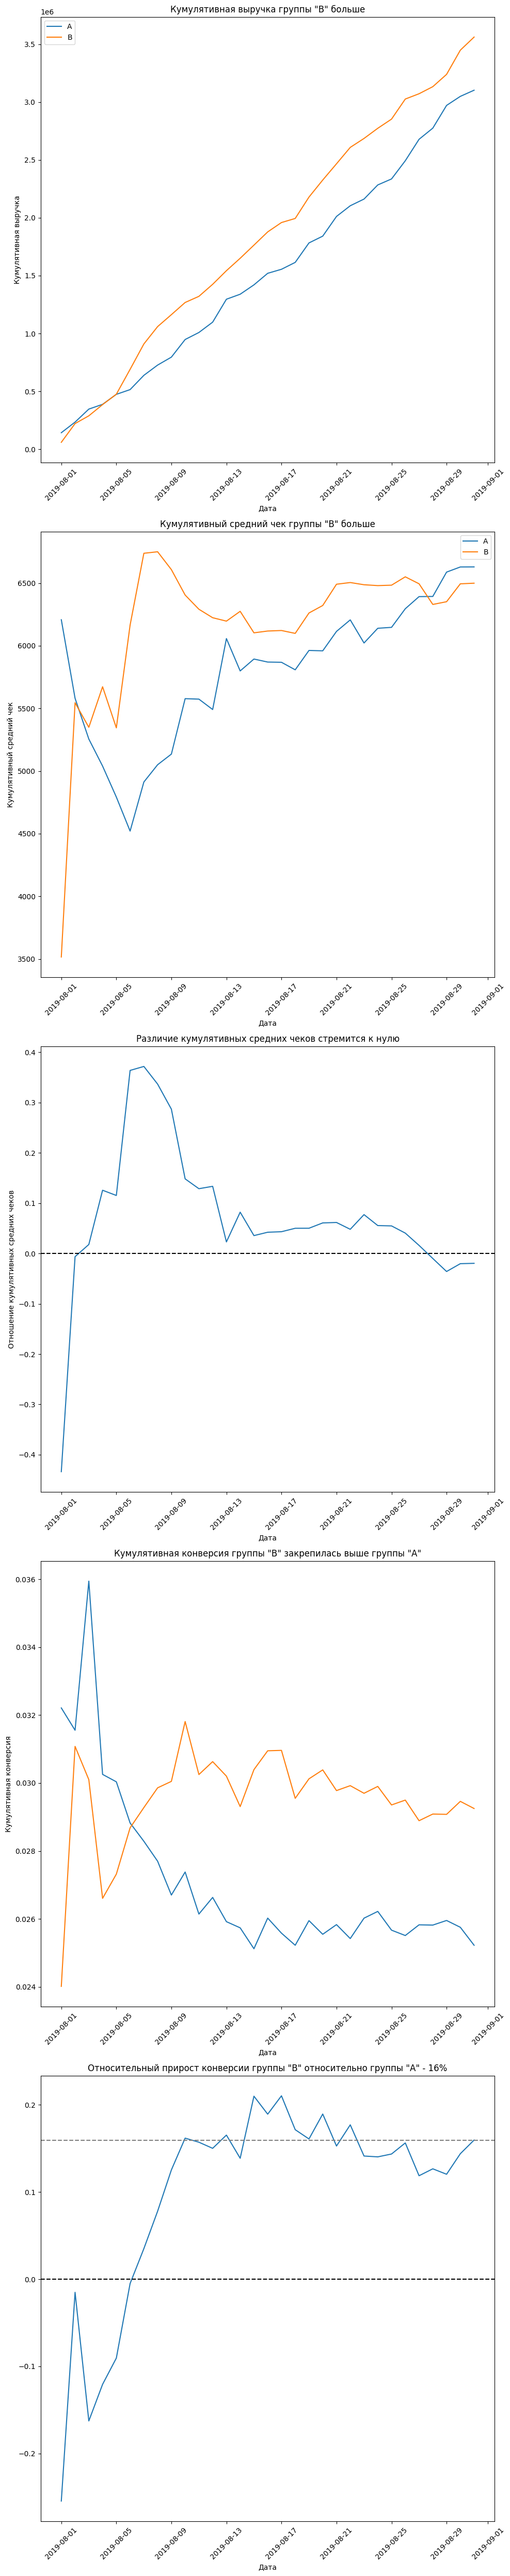

In [40]:
charts(df_united)

Кумулятивная выручка группы "B" со второй недели теста стабильно выше кумулятивной выручки группы "A".   
Кумулятивный средний чек нестабилен в первые 10 дней теста. Нестабильность может быть вызвана малым количеством данных в первые две недели теста и выбросами по стоимости и количеству заказов. В дальнейшем отношение кумулятивного среднего чека группы "B" к кумулятивному среднему чеку группы "A" стабилизируется на уровне близком к нулю.  
Кумулятивная конверсия нестабильна в первые 10 дней теста. Нестабильность может быть вызвана малым количеством данных в первые две недели теста и выбросами по стоимости и количеству заказов. В дальнейшем стабилизируется, для группы "B" значение держится выше кумулятивной конверсии группы "A" на 11-21%.

#### Расчет средней конверсии по группам

Для определения статистической значимости изменений задаем уровень значимости:

In [41]:
alpha = 0.05

Формулируем гипотезы:  
Гипотеза H0: среднее конверсии группы "A" равно среднему конверсии группы "B".  
Гипотеза H1: среднее конверсии группы "A" не равно среднему конверсии группы "B".

Для каждой группы собираем все визиты с заказами и без заказов воедино:

In [42]:
visits_group_a = conversion(df_visitors, orders_by_users_a, 'A')
visits_group_b = conversion(df_visitors, orders_by_users_b, 'B')

Рассчитываем статистическую значимость различий в конверсии между группами:

In [43]:
result_conversion = st.mannwhitneyu(visits_group_a, visits_group_b)
print('p-value: {}'.format(result_conversion.pvalue))
print('Относительный прирост конверсии группы "B": {:.3}'.format(visits_group_b.mean() / visits_group_a.mean() - 1))
if result_conversion.pvalue < alpha and visits_group_a.mean() < visits_group_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью конверсия группы "B" выше.')
elif result_conversion.pvalue < alpha and visits_group_a.mean() > visits_group_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью конверсия группы "A" выше.')
else:
      print('Не отвергаем нулевую гипотезу.')

p-value: 0.011054890057216164
Относительный прирост конверсии группы "B": 0.16
Отвергаем нулевую гипотезу: с высокой вероятностью конверсия группы "B" выше.


#### Расчет средних чеков по группам

Формулируем гипотезы:  
Гипотеза H0: средний чек группы "A" равен среднему чеку группы "B".  
Гипотеза H1: средний чек группы "A" не равен среднему чеку группы "B".

Рассчитываем статистическую значимость различия средних чеков между группами:

In [44]:
receipt_a = df_orders[df_orders['group']=='A']['revenue']
receipt_b = df_orders[df_orders['group']=='B']['revenue']
result_receipt = (st.mannwhitneyu(receipt_a, receipt_b))
print('p-value: {}'.format(result_receipt.pvalue))
print('Относительный прирост среднего чека группы "B": {:.3}'.format(receipt_b.mean() / receipt_a.mean() - 1))
if result_receipt.pvalue < alpha and receipt_a.mean() < receipt_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью средний чек группы "B" выше.')
elif result_receipt.pvalue < alpha and receipt_a.mean() > receipt_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью средний чек группы "A" выше.')
else:
      print('Не отвергаем нулевую гипотезу.')

p-value: 0.978951791448505
Относительный прирост среднего чека группы "B": -0.0196
Не отвергаем нулевую гипотезу.


***Вывод:***  
1. Кумулятивная выручка группы "B" со второй недели теста стабильно выше кумулятивной выручки группы "A".   
2. Кумулятивный средний чек нестабилен в первые 10 дней теста. Нестабильность может быть вызвана малым количеством данных в первые две недели теста и выбросами по стоимости и количеству заказов. В дальнейшем отношение кумулятивного среднего чека группы "B" к кумулятивному среднему чеку группы "A" стабилизируется на уровне близком к нулю.  
3. Кумулятивная конверсия нестабильна в первые 10 дней теста. Нестабильность может быть вызвана малым количеством данных в первые две недели теста и выбросами по стоимости и количеству заказов. В дальнейшем стабилизируется, для группы "B" значение держится выше кумулятивной конверсии группы "A" на 11-21%.
4. С высокой вероятностью конверсия группы "B" выше: относительный прирост конверсии группы "B" - 0.16, p-value: 0.011;  
5. С высокой вероятностью конверсии групп не различаются: относительный прирост конверсии группы "B" - минус 0.0196, p-value: 0.979;

### Анализ выбросов и всплесков: крайние значения данных
<a id="emissions"></a>

#### Определение границ выбросов и всплесков

Рассчитываем количество и сумму заказов каждого пользователя:

In [45]:
orders_by_users = (
    df_orders
        .groupby('user_id', as_index=False)
        .agg({'order_id': 'nunique', 'revenue' : 'sum'})
        .merge(df_orders[['user_id', 'group']], left_on='user_id', right_on='user_id', how='left')
        .rename(columns = {'order_id' : 'orders'})
    )
orders_by_users.head(5)

,user_id,orders,revenue,group
0,5114589,1,570.0,B
1,6958315,1,1490.0,B
2,11685486,1,6201.0,A
3,39475350,1,3990.0,B
4,47206413,1,730.0,B


Строим гистограммы для количества заказов по пользователям:

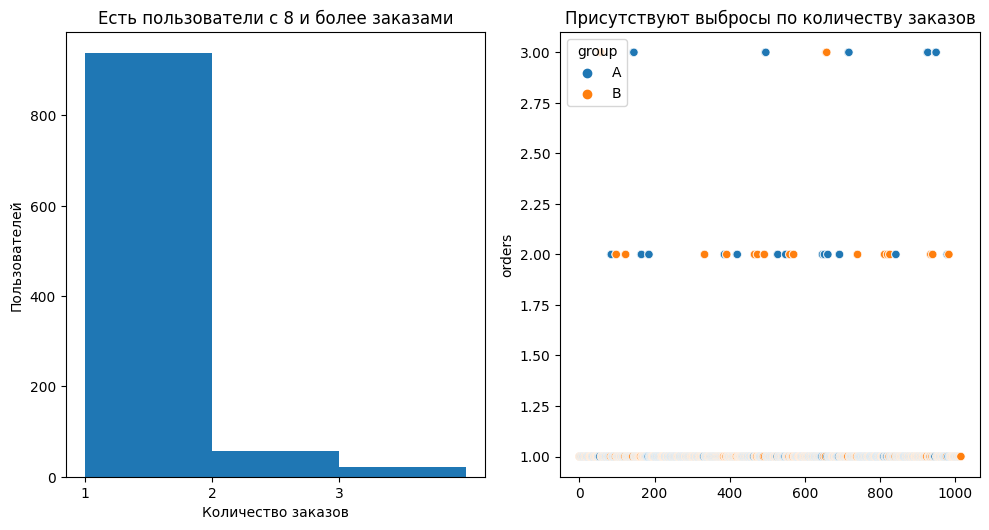

In [46]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = plt.hist(bins=range(1, 5), x=orders_by_users['orders'])
X_ticks_array=[i for i in range(1, orders_by_users['orders'].max()+1, 1)]
ax1 = plt.xticks(X_ticks_array)
ax1 = plt.title('Есть пользователи с 8 и более заказами')
ax1 = plt.ylabel('Пользователей')
ax1 = plt.xlabel('Количество заказов')


x_values_orders = pd.Series(range(0, len(orders_by_users)))
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.scatterplot(data=orders_by_users, x=x_values_orders, y='orders', hue='group')
ax2 = plt.title('Присутствуют выбросы по количеству заказов')

fig.tight_layout()
plt.show()

Рассчитываем 90-й, 95-й и 99-й выборочные перцентили количества заказов по пользователям:

In [47]:
orders_perc = np.percentile(orders_by_users['orders'], [90, 95, 99])
print('Не более 5% пользователей совершает {} и более заказов.'.format(int(orders_perc[1])))
print('Не более 1% пользователей совершает {} и более заказов.'.format(int(orders_perc[2])))

Не более 5% пользователей совершает 2 и более заказов.
Не более 1% пользователей совершает 3 и более заказов.


Строим гистограммы для выручки по пользователям:

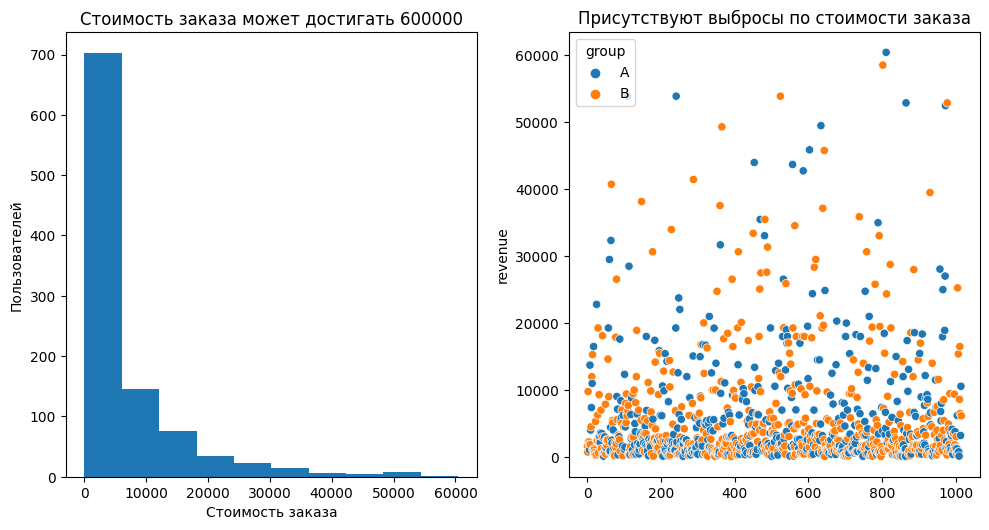

In [48]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = plt.hist(df_orders['revenue'])
ax1 = plt.title('Стоимость заказа может достигать 600000')
ax1 = plt.ylabel('Пользователей')
ax1 = plt.xlabel('Стоимость заказа')


x_values_revenue = pd.Series(range(0, len(df_orders)))
ax2 = fig.add_subplot(2, 2, 2)
#plt.scatter(x_values_revenue, df_orders['revenue'])
ax2 = sns.scatterplot(data=df_orders, x=x_values_revenue, y='revenue', hue='group')
ax2 = plt.title('Присутствуют выбросы по стоимости заказа')

fig.tight_layout()
plt.show()

Рассчитываем 90-й, 95-й и 99-й выборочные перцентили стоимости заказов по пользователям:

In [49]:
revenue_perc = np.percentile(df_orders['revenue'], [90, 95, 99])
print('Не более 5% пользователей совершило заказ на сумму {} и более.'.format(revenue_perc[1]))
print('Не более 1% пользователей совершило заказ на сумму {:.6} и более.'.format(revenue_perc[2]))

Не более 5% пользователей совершило заказ на сумму 25385.0 и более.
Не более 1% пользователей совершило заказ на сумму 45865.0 и более.


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v1:</b>
    
Диаграммы рассеяния и выбросы по 95 и по 99 персентилю определены полностью верно.

#### Очистка от аномалий значений

Убираем из рассмотрения 1% пользователей, совершивших наибольшее количество заказов:

In [50]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a.loc[orders_by_users_a['orders'] >= orders_perc[2]]['user_id'],
        orders_by_users_b.loc[orders_by_users_b['orders'] >= orders_perc[2]]['user_id'],
    ],
    axis=0,
)

Убираем из рассмотрения 1% пользователей, совершивших наиболее дорогие покупки:

In [51]:
users_with_expensive_orders = df_orders[df_orders['revenue'] >= revenue_perc[2]]['user_id']

Собираем отбракованные данные в одну таблицу:

In [52]:
abnormal_users_clean = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users_clean.head(5)

33     249864742
58     611059232
972    759473111
811    887908475
603    950626008
Name: user_id, dtype: uint64

Создаем таблицу заказов, очищенную от выбросов и пользователей, которые входят в обе группы:

In [53]:
df_orders_clean = df_orders[np.logical_not(df_orders['user_id'].isin(abnormal_users_clean))] \
                           [['order_id', 'user_id', 'date', 'revenue', 'group']].reset_index(drop=True)

Исключаем из исследования посещения не прошедших фильтрацию пользователей:

In [54]:
df_visitors_clean = reset_visitors(df_orders, df_orders_clean, df_visitors, abnormal_users_clean)

Исключено из исследования уникальных пользователей - 1.8%
Исключено из исследования посещений - 0.2%


Выводим данные заказов и визитов по группам:

In [55]:
display(pivot_table(df_orders_clean, df_visitors_clean))

,orders,revenue,users,visitors
group,,,,
A,445,2608560.0,433,18522.0
B,538,3297581.0,522,18702.0


Выводим информацию по очищенным данным:

In [56]:
information({'df_orders_clean' : df_orders_clean, 'df_visitors_clean' : df_visitors_clean})

df_orders_clean

Общая информация df_orders_clean:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   order_id  983 non-null    uint32        
 1   user_id   983 non-null    uint32        
 2   date      983 non-null    datetime64[ns]
 3   revenue   983 non-null    uint16        
 4   group     983 non-null    category      
dtypes: category(1), datetime64[ns](1), uint16(1), uint32(2)
memory usage: 18.6 KB


None

____________________________________________________

Описательная статистика числовых значений df_orders_clean:


,count,mean,std,min,25%,50%,75%,max
order_id,983.0,2.161925e+09,1.226251e+09,1062393.0,1.167230e+09,2.146401e+09,3.256781e+09,4.288552e+09
user_id,983.0,2.123190e+09,1.218879e+09,5114589.0,1.050885e+09,2.139466e+09,3.144053e+09,4.283872e+09
revenue,983.0,6.008282e+03,7.730754e+03,50.0,1.190000e+03,2.890000e+03,7.380000e+03,4.578000e+04


____________________________________________________

Процент пропущенных значений df_orders_clean:


order_id    0.0
user_id     0.0
date        0.0
revenue     0.0
group       0.0
dtype: float64

____________________________________________________

Случайная выборка датафрейма df_orders_clean:


,order_id,user_id,date,revenue,group
231,3140010296,3647934575,2019-08-02,1990,B
522,2516233682,1069983096,2019-08-20,3826,A
27,3601774485,2231389472,2019-08-15,6250,B
630,178265899,433951253,2019-08-07,5490,B
929,4099032419,2749453459,2019-08-13,5390,A


____________________________________________________
____________________________________________________

df_visitors_clean

Общая информация df_visitors_clean:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     category      
 2   visitors  62 non-null     float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 1.7 KB


None

____________________________________________________

Описательная статистика числовых значений df_visitors_clean:


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,600.387097,113.299307,358.0,524.0,616.5,702.75,766.0


____________________________________________________

Процент пропущенных значений df_visitors_clean:


date        0.0
group       0.0
visitors    0.0
dtype: float64

____________________________________________________

Случайная выборка датафрейма df_visitors_clean:


,date,group,visitors
30,2019-08-31,A,692.0
32,2019-08-02,B,578.0
33,2019-08-03,B,507.0
48,2019-08-18,B,731.0
51,2019-08-21,B,648.0


____________________________________________________
____________________________________________________



***Вывод:***

1. Из исследования исключены пользователи, совершившие более 2 заказов и заплатившие 45865 и более, - 1.8%. Соответственно,  из исследования исключены и их посещения - 0.2%.  
2. В группе "A" осталось 433 уникальных пользователя, в группе "B" - 522.

### Анализ очищенных данных
<a id="analysis_cleared_data"></a>

***Таблица orders***

Разделяем заказы разных групп по соответствующим датафреймам:

In [57]:
orders_by_users_clean_a = users_orders(df_orders_clean, 'A')
orders_by_users_clean_b = users_orders(df_orders_clean, 'B')

Создаем таблицы с количеством и суммой заказов по дням для каждой группы:

In [58]:
orders_daily_clean_a = orders_daily(df_orders_clean, 'A')
orders_daily_clean_b = orders_daily(df_orders_clean, 'B')

Создаем таблицы с кумулятивными данными заказов по дням для каждой группы:

In [59]:
orders_cummulative_clean_a = orders_cummulative(orders_daily_clean_a, 'A')
orders_cummulative_clean_b = orders_cummulative(orders_daily_clean_b, 'B')

***Таблица visitors***

Создаем таблицы с количеством посещений по дням для каждой группы:

In [60]:
visitors_daily_clean_a = visitors_daily(df_visitors_clean, 'A')
visitors_daily_clean_b = visitors_daily(df_visitors_clean, 'B')

Создаем таблицы с кумулятивными данными визитов по дням для каждой группы:

In [61]:
visitors_cummulative_clean_a = visitors_cummulative(visitors_daily_clean_a, 'A')
visitors_cummulative_clean_b = visitors_cummulative(visitors_daily_clean_b, 'B')

Объединяем таблицы:

In [62]:
df_united_clean = (
    orders_daily_clean_a.merge(
        orders_daily_clean_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_clean_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_clean_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_clean_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_clean_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_clean_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_clean_b, left_on='date', right_on='date', how='left')
)

Рассчитываем кумулятивную конверсию по группам:

In [63]:
df_united_clean['conversion_a'] = df_united_clean['orders_cummulative_a'] / df_united_clean['visitors_cummulative_a']
df_united_clean['conversion_b'] = df_united_clean['orders_cummulative_b'] / df_united_clean['visitors_cummulative_b']
df_united_clean.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b,conversion_a,conversion_b
0,2019-08-01,18,112340.0,17,59758.0,18,112340.0,17,59758.0,709.0,703.0,709.0,703.0,0.025388,0.024182
1,2019-08-02,18,89912.0,23,162043.0,36,202252.0,40,221801.0,616.0,578.0,1325.0,1281.0,0.027170,0.031226
2,2019-08-03,24,112473.0,14,67049.0,60,314725.0,54,288850.0,505.0,507.0,1830.0,1788.0,0.032787,0.030201
3,2019-08-04,11,41176.0,14,96890.0,71,355901.0,68,385740.0,709.0,762.0,2539.0,2550.0,0.027964,0.026667
4,2019-08-05,22,86383.0,21,89908.0,93,442284.0,89,475648.0,751.0,702.0,3290.0,3252.0,0.028267,0.027368


Рассчитываем, какой процент уникальных пользователей удалены из рассмотрения:

#### Диаграммы

Строим следующие диаграммы:  
- кумулятивная выручка;  
- кумулятивный средний чек;  
- различие кумулятивных средних чеков;  
- кумулятивная конверсия;  
- относительный прирост конверсии группы "B" относительно группы "A".

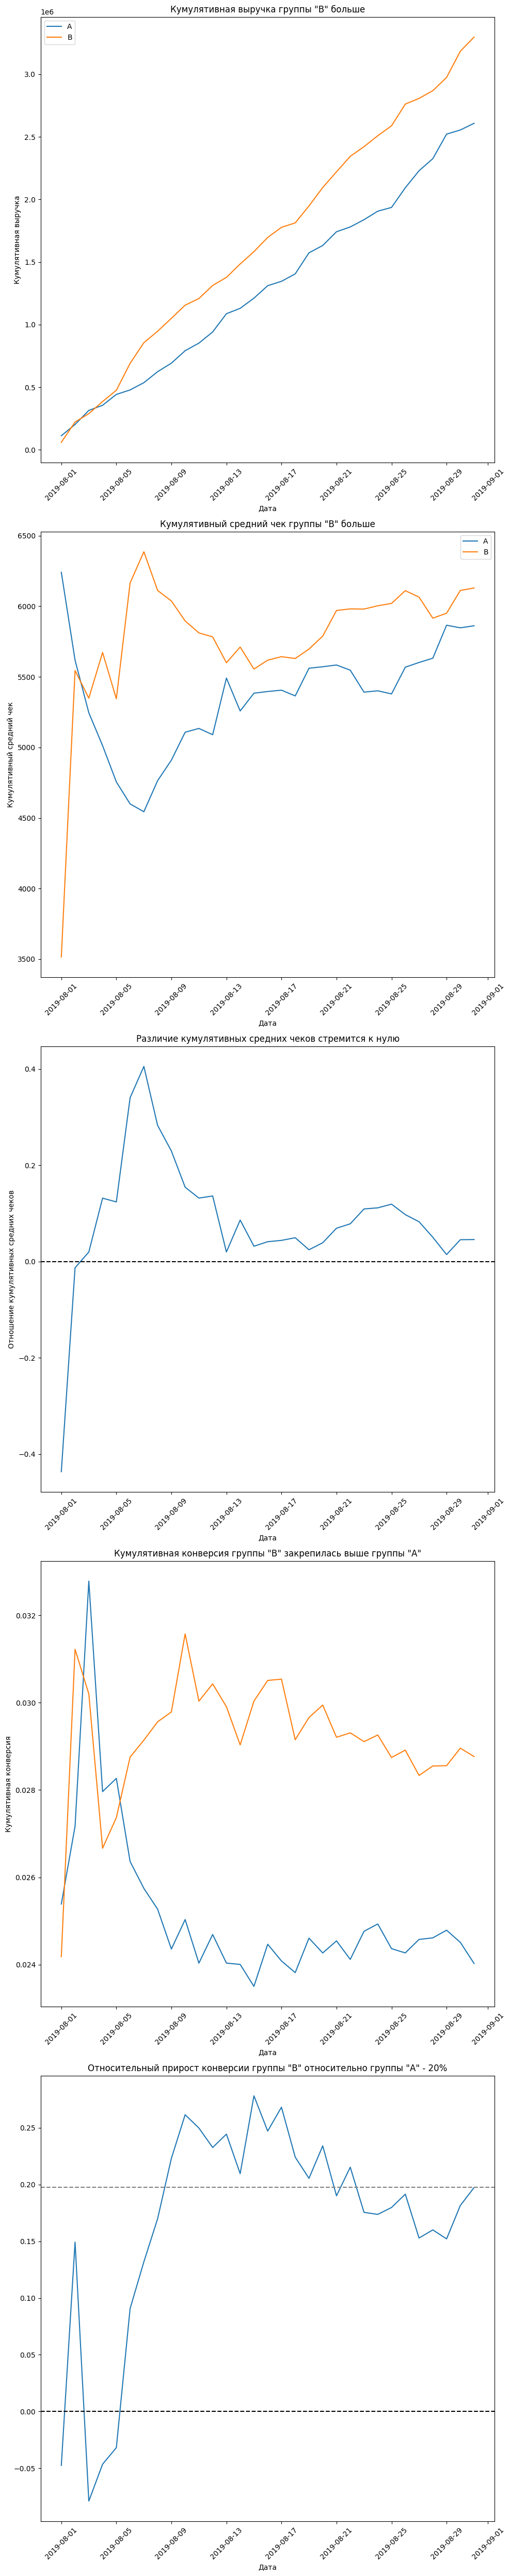

In [64]:
charts(df_united_clean)

Кумулятивная выручка группы "B" со второй недели теста стабильно выше кумулятивной выручки группы "A".   
Кумулятивный средний чек нестабилен в первые 14 дней теста. Нестабильность может быть вызвана малым количеством данных в первые две недели теста. В дальнейшем стабилизируется, для группы "B" значение держится выше кумулятивного среднего чека группы "A" на 1-14%.  
Кумулятивная конверсия нестабильна в первые 14 дней теста. Нестабильность может быть вызвана малым количеством данных в первые две недели теста. В дальнейшем стабилизируется, для группы "B" значение держится выше кумулятивной конверсии группы "A" на 15-26%.

#### Расчет средней конверсии по группам

Формулируем гипотезы:  
Гипотеза H0: среднее конверсии группы "A" равно среднему конверсии группы "B".  
Гипотеза H1: среднее конверсии группы "A" не равно среднему конверсии группы "B".

Для каждой группы собираем все визиты с заказами и без заказов воедино:

In [65]:
visits_group_clean_a = conversion(df_visitors_clean, orders_by_users_clean_a, 'A')
visits_group_clean_b = conversion(df_visitors_clean, orders_by_users_clean_b, 'B')

Рассчитываем статистическую значимость различий в конверсии между группами:

In [66]:
result_conversion_clean = st.mannwhitneyu(visits_group_clean_a, visits_group_clean_b)
print('p-value: {}'.format(result_conversion_clean.pvalue))
print('Относительный прирост конверсии группы "B": {:.3}'.format(visits_group_clean_b.mean() / visits_group_clean_a.mean() - 1))
if result_conversion_clean.pvalue < alpha and visits_group_clean_a.mean() < visits_group_clean_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью конверсия группы "B" выше.')
elif result_conversion_clean.pvalue < alpha and visits_group_clean_a.mean() > visits_group_clean_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью конверсия группы "A" выше.')
else:
      print('Не отвергаем нулевую гипотезу.')

p-value: 0.005650719969272927
Относительный прирост конверсии группы "B": 0.197
Отвергаем нулевую гипотезу: с высокой вероятностью конверсия группы "B" выше.


#### Расчет средних чеков по группам

Формулируем гипотезы:  
Гипотеза H0: средний чек группы "A" равен среднему чеку группы "B".  
Гипотеза H1: средний чек группы "A" не равен среднему чеку группы "B".

Рассчитываем статистическую значимость различия средних чеков между группами:

In [67]:
receipt_clean_a = df_orders_clean[df_orders_clean['group']=='A']['revenue']
receipt_clean_b = df_orders_clean[df_orders_clean['group']=='B']['revenue']
result_receipt_clean = (st.mannwhitneyu(receipt_clean_a, receipt_clean_b))
print('p-value: {}'.format(result_receipt_clean.pvalue))
print('Относительный прирост среднего чека группы "B": {:.3}'.format(receipt_b.mean() / receipt_a.mean() - 1))
if result_receipt_clean.pvalue < alpha and receipt_clean_a.mean() < receipt_clean_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью средний чек группы "B" выше.')
elif result_receipt_clean.pvalue < alpha and receipt_clean_a.mean() > receipt_clean_b.mean():
      print('Отвергаем нулевую гипотезу: с высокой вероятностью средний чек группы "A" выше.')
else:
      print('Не отвергаем нулевую гипотезу.')

p-value: 0.8745553758297769
Относительный прирост среднего чека группы "B": -0.0196
Не отвергаем нулевую гипотезу.


***Вывод:***
<a id="final_2"></a>
1. При удалении выбросов по количеству и сумме заказов, количество уникальных пользователей уменьшено на 1.8%.  
2. Кумулятивная выручка нестабильна в первые 5 дней теста. В дальнейшем стабилизируется и для группы "B" она держится выше кумулятивной выручки группы "A". 
3. Кумулятивный средний чек нестабилен в первые 14 дней теста. В дальнейшем стабилизируется, для группы "B" значение держится выше кумулятивного среднего чека группы "A" на 1-14%.  
Нестабильность может быть вызвана малым количеством данных в первые две недели теста.  
Различие между средними чеками "А" и "Б" статистически не значимо: p-value - 0.875.  
5. Кумулятивная конверсия нестабильна в первые 14 дней теста. В дальнейшем стабилизируется, для группы "B" значение держится выше кумулятивной конверсии группы "A" на 15-26%.  
Нестабильность может быть вызвана малым количеством данных в первые две недели теста.  
Различие между конверсиями "А" и "Б" статистически значимо: p-value - 0.006.
6. Очистка данных от выбросов привела к увеличению статистической значимости различия между конверсиями (p-value уменьшено с 0.011 до 0.006) и между средними чеками (p-value уменьшено с 0.979 до 0.875).

## Общий вывод:
<a id="final"></a>

1. Наибольший приоритет для проведения A/B теста имеет гипотеза "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
2. По результатам первого месяца A/B теста группа "B" по рассматриваемым параметрам - выручка, конверсия, средний чек - показала лучшие результаты: в течение последних двух недель параметры группы "B" по очищенным данным стабильно выше.  
3. Разница между средними чеками групп "A" и "B" статистически незначима (p-value 0.875), но разница между конверсиями статистически значима (0.006).  
Вышеизложенное дает основание утверждать, что группа "B" показывает стабильно более высокий результат, нежели группа "A", и проведение A/B теста можно остановить.